# Comandos SQL desde python - Cómo manipular una base de datos

En el presente documento se mostrará cómo realizar consultas y hacer modificaciones a una base de datos MySQL desde python. Los datos que utilizaremos para mostrar las instrucciones se obtuvieron del sitio web https://www.inegi.org.mx

Comenzaremos importando las librerías necesarias para descargar los datos

In [1]:
# Importando librerías
import urllib.request
import os
import zipfile
import numpy as np

In [2]:
# Definiendo nombres de directorios para la descarga de los archivos
url = "https://www.inegi.org.mx/contenidos/programas/transporteurbano/datosabiertos/etup_mensual_csv.zip"
archivo = "trans_urb.zip"
subdir = "./data/"

Una vez definida la url y los directorios procedemos a la descarga

In [3]:
# Descargando datos
if not os.path.exists(archivo):
    if not os.path.exists(subdir):
        os.makedirs(subdir)
    urllib.request.urlretrieve(url, subdir + archivo)  
    with zipfile.ZipFile(subdir + archivo, "r") as zip_ref:
        zip_ref.extractall(subdir)

Utilizando la librería **pandas** podemos obtener los datos descargados como un dataframe. Estos recogen la información sobre el transporte en México del año 1998 a 2022

In [23]:
import pandas as pd

# Obteniendo datos
dir = subdir + '/conjunto_de_datos/' + 'etup_mensual_tr_cifra_1986_2022.csv'

df = pd.read_csv(dir, encoding='utf-8', index_col=False)

df.head(2)

,ANIO,ID_MES,TRANSPORTE,VARIABLE,ID_ENTIDAD,ID_MUNICIPIO,VALOR,ESTATUS
0,1986,1,Red de Transporte de Pasajeros,Autobuses en operación de lunes a viernes,9,999,4201.0,Cifras Definitivas
1,1986,1,Red de Transporte de Pasajeros,Autobuses en operación de sábado a domingo,9,999,2601.0,Cifras Definitivas


Analicemos si hay valores faltantes

In [5]:
df.isnull().sum()

ANIO              0
ID_MES            0
TRANSPORTE        0
VARIABLE          0
ID_ENTIDAD        0
ID_MUNICIPIO      0
VALOR           151
ESTATUS           0
dtype: int64

Los valores faltantes se encuentran el la columna donde se almacena precisamente la medición de las variables, por tanto podemos eliminarlos

In [6]:
df.dropna(inplace=True)

## Creando una base de datos 🚀

Para poder manipular una base de datos MySQL desde python primero debemos crearla.
El primer paso es iniciar sesión en MySQL desde una interfaz de línea de comandos (CLI) y ejecutar la siguiente instrucción con el usuario y luego contraseña correspondiente.

```
mysql -u usuario -p
```

A continuaciónn, creamos la base de datos. Aquí además, se creó una tabla en correspondencia con los datos obtenidos de nuestro csv

```
CREATE DATABASE transporte;
USE transporte;

CREATE TABLE IF NOT EXISTS transportes(
    id BIGINT UNSIGNED AUTO_INCREMENT NOT NULL,
    anio SMALLINT,
    id_mes SMALLINT,
    transporte VARCHAR(255),
    variable VARCHAR(255),
    id_entidad SMALLINT,
    id_municipio SMALLINT,
    valor DOUBLE,
    estatus VARCHAR(255),    
    PRIMARY KEY(id)
);
```

## Insertando datos desde python 📑

Con la librería `pymysql` se pueden ejecutar comandos de MySQL desde python. Veamos cómo conectarnos a la base de datos utilizando `try/except` para capturar cualquier error

In [8]:
import pymysql

try:
    connection = pymysql.connect(host='localhost',
                             user='root',
                             password='123456',
                             db='transporte')
    print("Conexión correcta")
except (pymysql.err.OperationalError, pymysql.err.InternalError) as e:
    print("Ocurrió un error al conectar: ", e)

Conexión correcta


El objeto creado `connection` representa la base de datos en python. La `connection`  usa un puntero `cursor` que mantiene el rastro de donde estamos en la base de datos. Este puntero es quién se usa para crear consultas y hacer modificaciones. Veamos cómo actualizar la tabla `transportes`, utilizando este puntero, con los datos obtenidos de nuestro csv y almacenado en un dataframe.

Primero, definiremos una función que inserte un nuevo registro en la tabla.

In [9]:
"""Función que inserta un nuevo registro en la tabla transportes """
def add_register(database_name, new_register):
    try:
        connection = pymysql.connect(host='localhost',
                             user='root',
                             password='123456',
                             db=database_name)
        try:
            with connection.cursor() as cursor:
                query = "INSERT INTO transportes(anio, id_mes, transporte, variable, id_entidad, id_municipio, valor, estatus) VALUES (%s, %s, %s, %s, %s, %s, %s, %s);"          
                cursor.execute(query, new_register)
            connection.commit()
        finally:
            connection.close()
    
    except (pymysql.err.OperationalError, pymysql.err.InternalError) as e:
        print("Ocurrió un error al conectar: ", e)


Con esta nueva función podemos insertar cada instancia de nuestro dataframe en la base de datos. Esta instrucción demorará varios minutos en ejucutarse debido a la cantidad de datos en nuestro dataframe 🙄

In [10]:
for i in range(len(df)):
  add_register('transporte', tuple(df.iloc[i, :]))

## Realizando consultas 🔎

Una de las cosas más comunes en el trabajo con base de datos son las consultas. Crearemos una función de python para realizarlas

In [11]:
"""Función que realiza una consulta en la base de datos `database_name`"""
def get_query(database_name, query):       
    try:
        connection = pymysql.connect(host='localhost',
                                 user='root',
                                 password='123456',
                                 db=database_name)
        try:
            with connection.cursor() as cursor:
                # En este caso no necesitamos limpiar ningún dato
                cursor.execute(query)            
                
                # Con fetchall traemos todas las filas
                results = cursor.fetchall()
                
                #Imprimiendo los resultados uno debajo de otro
                for r in results:
                        print(r)
        
        finally:
            connection.close()
    except (pymysql.err.OperationalError, pymysql.err.InternalError) as e:
        print("Ocurrió un error al conectar: ", e)

El siguiente código muestra un ejemplo de consulta a la base de datos utilizando la recien creada función `get_query`

In [12]:
query = "SELECT id, anio, id_mes FROM transportes WHERE variable = 'Autobuses en operación de lunes a viernes' AND valor > 4400;"

get_query('transporte', query)

(122, 1986, 12)
(166, 1987, 4)
(177, 1987, 5)


## Creando una vista 👀

Desde python también podemos crearle vistas a las bases de datos. Tan solo una llamada a `CREATE VIEW` en una consulta y listo!

Pero antes creemos una función para realizar modificaciones a una base de datos

In [13]:
"""Función que realiza una modificación a la base de datos `database_name`"""
def alter_bd(database_name, query):  
    try:
        connection = pymysql.connect(host='localhost',
                                 user='root',
                                 password='123456',
                                 db=database_name)
        try:
            with connection.cursor() as cursor:
                # En este caso no necesitamos limpiar ningún dato
                cursor.execute(query)
            connection.commit()
        finally:
                connection.close()
        
    except (pymysql.err.OperationalError, pymysql.err.InternalError) as e:
        print("Ocurrió un error al conectar: ", e)
                

Utilizando la función de python anterior podremos crear una vista como a continuación se muestra

In [14]:
query = "CREATE VIEW consultas_2022 AS SELECT * FROM transportes WHERE anio = 2022;"
alter_bd('transporte', query)

## Creando una función almacenada ⚙️

Es posible además, crear funciones almacenadas desde python para que luego sean aplicadas a la base de datos. En nuestro caso creamos una función que devuelve el nombre del estado o entidad según el número de id.

Primero veamos cuales son los id_entidad que extisten en el dataframe


In [15]:
df.ID_ENTIDAD.value_counts()

9     9930
14    6509
19    4354
15    1142
13     912
22     463
8      147
Name: ID_ENTIDAD, dtype: int64

Creamos la función y llamamos a `alter_bd` para su integración a la base de datos

In [16]:
query = """CREATE FUNCTION entity_name(id_entity INT(11)) RETURNS VARCHAR(20)
DETERMINISTIC
BEGIN
    DECLARE name VARCHAR(20);

    IF id_entity = 8 THEN
		SET name = 'Chihuahua';
    ELSEIF id_entity = 9 THEN
        SET name = 'Ciudad de Mexico';
    ELSEIF id_entity = 13 THEN
        SET name = 'Hidalgo';
    ELSEIF id_entity = 14 THEN
        SET name = 'Jalisco';
    ELSEIF id_entity = 15 THEN
        SET name = 'Mexico';
    ELSEIF id_entity = 19 THEN
        SET name = 'Nuevo Leon';
    ELSEIF id_entity = 22 THEN
        SET name = 'Queretaro';
    END IF;
	RETURN (name);
END
"""

alter_bd('transporte', query)

A continuación, se muestra un ejemplo de uso de la función que hemos creado

In [17]:
query = "SELECT anio, entity_name(id_entidad) FROM transportes WHERE variable = 'Autobuses en operación de lunes a viernes' AND valor = 0;"

get_query('transporte', query)

(1995, 'Ciudad de Mexico')


## Creando procedimiento almacenado 📋

Podemos crear un procedimiento almacenado de forma similar a como creamos las funciones almacenadas. En este caso, es una consulta  que muestra el año, el nombre de la entidad y el valor según la variable de entrada 

In [18]:
query = """CREATE PROCEDURE show_variable(IN var VARCHAR(255))
    BEGIN
    SELECT anio, entity_name(id_entidad), id_municipio, valor
    FROM transportes
    WHERE variable = var;
    END
"""
alter_bd('transporte', query)

A continuación se muestra un ejemplo de su uso.

In [21]:
query = "CALL show_variable('Pasajeros transportados')"

connection = pymysql.connect(host='localhost',
                             user='root',
                             password='123456',
                             db='transporte')

df_procedure = pd.read_sql_query(query, connection)
connection.close()

df_procedure.head()

,anio,entity_name(id_entidad),id_municipio,valor
0,1986,Ciudad de Mexico,999,172000400.0
1,1986,Ciudad de Mexico,999,110245300.0
2,1986,Ciudad de Mexico,999,161299600.0
3,1986,Ciudad de Mexico,999,98372400.0
4,1986,Ciudad de Mexico,999,157600900.0


Note que se almacenaron los resultados de la consulta en un dataframe, utilizando el módulo `read_sql_query` de **pandas**. Esto nos facilita visualizar los datos.

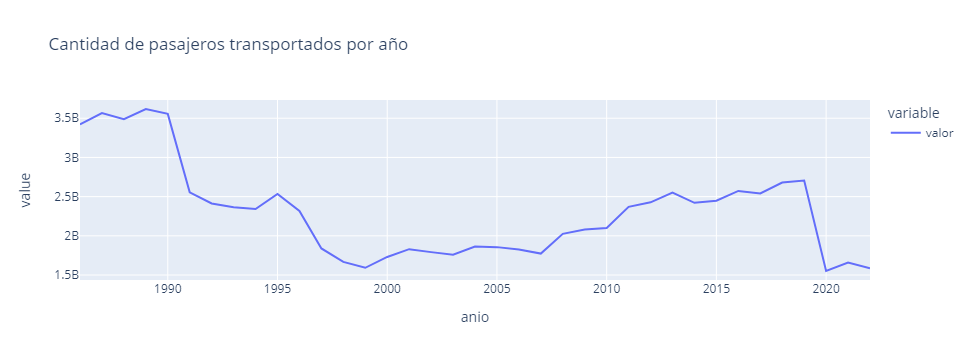

In [24]:
import plotly.express as px

fig = px.line(df_procedure.groupby('anio').sum()['valor'], title='Cantidad de pasajeros transportados por año')

fig.show()

# Conclusiones 💣

A través de las instrucciones del presente documento hemos podido consultar y manipular una base de datos MYSQL desde python utilizando la librería `pymysql`.  Las modificaciones creadas resultaron en una vista, una función y un procedimiento almacenado en la base de datos. Este último fue usado junto al módulo `read_sql_query` de **pandas**, para crear un dataframe con el que poder generar tablas y gráficos.  